1. Com base no dataset de empre stimos (loan.csv) disponí vel em:
https://github.com/josenalde/machinelearning/blob/main/src/dataset/loan.csv,
desenvolver modelo de aprendizagem de ma quina para classificaça o bina ria de
liberaça o de empre stimo. Sugere-se as etapas seguintes, mas na o restritas a estas:

In [ ]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.datasets import fetch_openml
from scipy.ndimage.interpolation import shift
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# A)

# Pegar o arquivo csv direto do github
df = pd.read_csv("https://raw.githubusercontent.com/josenalde/machinelearning/refs/heads/main/src/dataset/loan.csv")

# Realizar downsampling da quantidade maior
df_majority = df[df["Loan_Status"] == 'Y']
df_minority = df[df["Loan_Status"] == 'N']

#422 - sim e 192 - não

#usando o resample
df_majority_downsampled = resample(
    df_majority,
    replace = False,
    n_samples = len(df_minority),
    random_state = 42
)

df_balanced = pd.concat([df_majority_downsampled, df_minority])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
# Verificar o balanceamento
df_balanced["Loan_Status"].value_counts() #192 - sim e 192 - não

# # Aplicando o downsampling
# classe_y_downsampled = classe_y.sample(n=len(classe_n), random_state=42)

# # Concatenando as classes
# df_balanceado = pd.concat([classe_y_downsampled, classe_n])

# # Embaralhando o DataFrame
# df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

# df_balanceado['Loan_Status'].value_counts()

In [ ]:
# B)

# Criando um dataset onde serão feitas as modificações
df_modified = df_balanced.drop(columns=["Loan_ID", "CoapplicantIncome", "Loan_Amount_Term", "Credit_History", "Property_Area"])

# Mostrando as colunas do novo dataset
df_modified.head()

In [ ]:
# C)

# verificar e Preencher dados faltantes por coluna
cols_to_fill = ['Dependents', 'Self_Employed', 'Married', 'Gender', 'LoanAmount']
for col in cols_to_fill:
    df_modified[col] = df_modified[col].fillna(df_modified[col].mode()[0])

#mostrando as colunas do novo dataset
df_modified.head()

In [ ]:
# D)

#mostrando a soma dos valores faltantes por coluna
df_modified.isnull().sum()

In [ ]:
# E)

#atribuindo o LabelEncoder
encoder = LabelEncoder()

# Usando o encoder nas colunas
cols_to_encode = ['Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Status']
for col in cols_to_encode:
    df_modified[col] = encoder.fit_transform(df_modified[col])

#mostrando as colunas
df_modified.head()

In [ ]:
# F)

#modificando o valor de '3+' para '3'
df_modified['Dependents'] = df_modified['Dependents'].replace('3+', 3).astype(int)

#vendo se foram modificados
df_modified

In [ ]:
from pickle import FALSE
# G)

#atribuindo o scaler
scaler = StandardScaler(with_std=True, with_mean=False)

numerical_columns = ['Dependents', 'ApplicantIncome', 'LoanAmount']

df_modified[numerical_columns] = scaler.fit_transform(df_modified[numerical_columns])

# Salvar o scaler utilizado no treinamento
dump(scaler, "scaler.pkl")
print("Scaler salvo como 'scaler.pkl'")

df_modified.head()

In [ ]:
X = df_modified.drop('Loan_Status', axis=1)
y = df_modified['Loan_Status']

def model_val(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print(f"{model}  AUC = {roc_auc_score(y_test, y_predict)}")
    score = cross_val_score(model, X, y, cv=5, scoring='roc_auc')


In [ ]:
pipelines = {
    'Logistic Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('classifier', LogisticRegression())
    ]),
    'Random Forest': Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('classifier', RandomForestClassifier())
    ]),
    'Gradient Boosting': Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('classifier', GradientBoostingClassifier())
    ]),
    'SVM': Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('classifier', SVC(probability=True))
    ]),
    'KNN': Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('classifier', KNeighborsClassifier())
    ])
}

# Definição de grades de parâmetros para cada modelo
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l2']
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [5, 10, None]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.05, 0.1, 0.2]
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    }
}

# armazenando os resultados das AUCs
auc_scores = {}
best_model_name = ""
best_auc = 0
best_pipeline = None
# modelos e seleção do melhor com base na AUC
plt.figure(figsize=(10, 8))
for name, pipeline in pipelines.items():
    print(f"Treinando modelo: {name}")
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, n_jobs=-1, scoring='roc_auc')
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    # divisão do conjunto de teste e treino
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    # calcular AUC
    auc = roc_auc_score(y_test, y_prob)
    auc_scores[name] = auc
    print(f"{name} - AUC: {auc}\n")

    # pegar o melhor modelo
    if auc > best_auc :
        best_auc = auc
        best_model_name = name
        best_pipeline = best_model

    # curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

print(best_model.get_params())
# curva ROC geral
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC')
plt.legend()
plt.show()

# Exibir os AUCs de todos os modelos
print("\nResultados das AUCs:")
for model, auc in auc_scores.items():
    print(f"{model}: AUC = {auc:.4f}")


In [ ]:
# Salvar apenas o pipeline ajustado do melhor modelo
if best_pipeline:
    dump(best_pipeline, "modelo_final.pkl")
    print(f"Pipeline salvo como 'modelo_final.pkl'. Melhor modelo: {best_model_name} com AUC = {best_auc:.2f}")

Pipeline salvo como 'modelo_final.pkl'. Melhor modelo: Random Forest com AUC = 1.00


2. Com base no dataset de imo veis na califo rnia (housing.csv) disponí vel em:
https://github.com/josenalde/machinelearning/blob/main/src/dataset/housing.c
 sv, desenvolver modelo de aprendizagem de ma quina para regressa o de valor de
imo vel (‘median_house_value’). Sugere-se as etapas seguintes, mas na o restritas a
estas:

3. Com base no notebook estudado mnist_sgd disponível em: https://github.com/josenalde/machinelearning/blob/main/src/mnist_sgd.ipynb, escreva uma funça o que possa mover
uma imagem do MNIST em qualquer direça o (left, right, up, down) em X pixels. Pode
começar testando X=1 e as adicione ao conjunto de treinamento. Faça a classificaça o
multiclasse com o SGD e veja se os resultados melhoraram em termos de confusa o
com os nu meros. Para esta funça o, considere usar o me todo shift() do mo dulo
scipy.ndimage.interpolation. Por exemplo shift(image, [2,1], cval=0) desloca a
imagem dois pixels para baixo e um pixel a  direita.

In [ ]:
# -------------- Carregando e Visualizando os Dados -------------- #

mnist = fetch_openml('mnist_784', version=1, parser='auto')

# Verificando as chaves do dataset
print(mnist.keys())

X, y = mnist.data, mnist.target
print(X.shape)
print(y.shape)
print(y.value_counts())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
(70000, 784)
(70000,)
class
1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
Name: count, dtype: int64


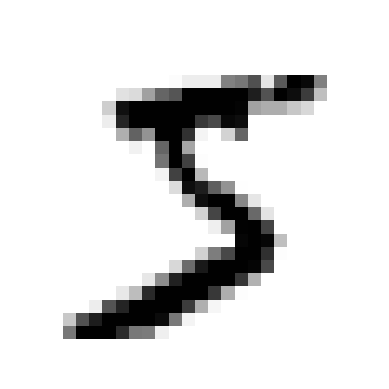

In [ ]:
# -------------- Visualizando uma amostra de imagem -------------- #

some_digit = X.loc[0,:]  # A amostra de índice 0
some_digit_np = some_digit.to_numpy()
some_digit_image = some_digit_np.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [ ]:
# -------------- Preprocessando os Dados -------------- #

# Convertendo os labels para inteiros
y = y.astype(np.uint8)

In [ ]:
# -------------- Dividindo em treino e teste -------------- #

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
# -------------- Função para Deslocar Imagens -------------- #

def move_image(image, shift_x, shift_y):
    """
    Usando a função shift Desloca a imagem para a direção especificada pelos parâmetros shift_x e shift_y.
    """
    return shift(image.reshape(28, 28), [shift_y, shift_x], cval=0).reshape(784)

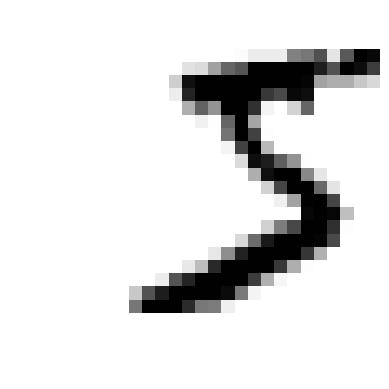

In [ ]:
# -------------- Testando a função com deslocamento de 1 pixel -------------- #

shifted_image = move_image(X_train.loc[0].to_numpy(), 2, 1) #testando com 5 e -2

plt.imshow(shifted_image.reshape(28,28), cmap='binary')
plt.axis('off')
plt.show()

In [ ]:
# -------------- Adicionando imagens deslocadas ao conjunto de treino -------------- #

X_train_shifted = np.array([move_image(img, 2, 1) for img in X_train.to_numpy()])
X_train = np.vstack([X_train.to_numpy(), X_train_shifted])
y_train = np.concatenate([y_train, y_train])

In [ ]:
# -------------- Treinando o Classificador com SGD -------------- #

model_sgd = SGDClassifier(random_state=42)
model_sgd.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [ ]:
# -------------- Avaliando o Classificador -------------- #

# Fazendo o predict com o modelo sgd
some_digit_pred = model_sgd.predict([some_digit])

In [ ]:
# -------------- acurácia com validação cruzada -------------- #

cross_val_score(model_sgd, X_train, y_train, cv=5, scoring='accuracy')

array([0.85004167, 0.78804167, 0.85045833, 0.869875  , 0.8675    ])

In [ ]:
# -------------- Realizando previsão com validação cruzada -------------- #

y_train_pred = cross_val_predict(model_sgd, X_train, y_train, cv=5)

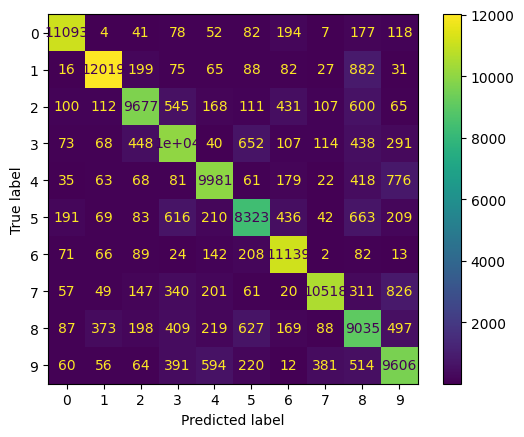

In [ ]:
# -------------- Exibindo a matriz de confusão -------------- #

cm = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_sgd.classes_)
disp.plot()

In [ ]:
# -------------- Relatório de classificação -------------- #

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     11846
           1       0.93      0.89      0.91     13484
           2       0.88      0.81      0.84     11916
           3       0.80      0.82      0.81     12262
           4       0.86      0.85      0.85     11684
           5       0.80      0.77      0.78     10842
           6       0.87      0.94      0.91     11836
           7       0.93      0.84      0.88     12530
           8       0.69      0.77      0.73     11702
           9       0.77      0.81      0.79     11898

    accuracy                           0.85    120000
   macro avg       0.85      0.84      0.84    120000
weighted avg       0.85      0.85      0.85    120000



In [ ]:
# -------------- Ajustando a Função de Threshold -------------- #

# Cálculo da função de decisão e ajuste do threshold
y_scores = model_sgd.decision_function([some_digit])
thresh = 0
y_some_digit_pred = (y_scores > thresh)
print(y_some_digit_pred)

[[False False False  True False False False False False False]]


In [ ]:
# -------------- Aumentando o threshold -------------- #

thresh = 3000
y_some_digit_pred = (y_scores > thresh)
print(y_some_digit_pred)

[[False False False False False False False False False False]]


In [ ]:
# -------------- Curva Precision-Recall -------------- #
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(model_sgd, X_train, y_train, cv=5, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precisão')
    plt.plot(thresholds, recalls[:-1], 'r-', label='Sensibilidade')
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:


from sklearn.metrics import roc_curve

tfp, tvp, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(tfp, tvp, label='roc'):
    plt.plot(tfp, tvp, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    plt.grid()
    plt.xlabel('Taxa de Falsos Positivos (1 - especificidade)')
    plt.ylabel('Taxa de Verdadeiros Positivos (sensibilidade)')

plot_roc_curve(tfp, tvp)
plt.show()

In [ ]:
# -------------- Avaliação com Random Forest -------------- #

from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=42)
y_probas_rf = cross_val_predict(model_rf, X_train, y_train, cv=5, method='predict_proba')

In [ ]:
# -------------- Calculando ROC para Random Forest -------------- #

y_scores_rf = y_probas_rf[:,1]  # Probabilidade da classe positiva (5)
tfp_rf, tvp_rf, thresholds_rf = roc_curve(y_train, y_scores_rf)

In [ ]:
# -------------- Plotando a comparação das curvas ROC -------------- #

def plot_roc_curve(tfp_1, tvp_1, tfp_2, tvp_2, label_1, label_2):
    plt.plot(tfp_1, tvp_1, linewidth=2, label=label_1)
    plt.plot(tfp_2, tvp_2, 'r', linewidth=2, label=label_2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    plt.grid()
    plt.xlabel('Taxa de Falsos Positivos (1 - especificidade)')
    plt.ylabel('Taxa de Verdadeiros Positivos (sensibilidade)')

plot_roc_curve(tfp, tvp, tfp_rf, tvp_rf, 'SGD', 'RandomForest')
plt.show()

In [ ]:
# -------------- Avaliação com SVM (One vs Rest) -------------- #

from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

svm_ovr_model = OneVsRestClassifier(SVC())
svm_ovr_model.fit(X_train, y_train)

In [ ]:
# -------------- Previsão e avaliação -------------- #

svm_ovr_model.predict([some_digit])

In [ ]:
# -------------- Classificação Multiclasse -------------- #

model_sgd.fit(X_train, y_train)
model_sgd.predict([some_digit])

In [ ]:
# -------------- Avaliação com Validação Cruzada -------------- #

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [ ]:
# -------------- Realizando a avaliação com o modelo SGD -------------- #

cross_val_score(model_sgd, X_train_scaled, y_train, scoring='accuracy', cv=3, n_jobs=-1)

In [ ]:
# -------------- Previsões com validação cruzada -------------- #

y_train_pred = cross_val_predict(model_sgd, X_train_scaled, y_train, cv=3, n_jobs=-1)

In [ ]:
# -------------- Exibindo a matriz de confusão -------------- #

conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

4. Pesquisa e uso/exemplo de uma das ferramentas em caso simples de validação sobre data-app: streamlit

In [ ]:
https://gdp-pop-ml.streamlit.app/